# Bernoulli RV in BSC Channel

Consider a bits $X[n] \sim B(p)$ transmitted over a channel. The considered channel is a BSC channel with bit flip probability $f$.
The channel is therefore modeled as a Bernoulli process: $W[n]\sim B(f)$. The received bit is therefore:

$$
Y[n]=X[n]\oplus W[n]
$$

## Distribution of $Y[n]$
For brevity, we omit the index $n$. The distribution of of $Y$, parametrized by $p$ and $f$ is:

$$
f_{Y\vert p,f}(Y=y\vert p,f) = (1-f)p^y(1-p)^{1-y} + fp^{1-y}(1-p)^y
$$

This can be alternatively written as:

$$
f_{Y\vert p,f}(Y=y\vert p,f) = p^y(1-p)^{1-y} + f\underbrace{\left[p^{1-y}(1-p)^y - p^y(1-p)^{1-y}\right]}_c
$$

Analyzing this we note that $c$ equals:

$$
c = \begin{cases}
&2p -1, & y=0\\
&1 - 2p, & y=1
\end{cases}\\
\Rightarrow c = (-1)^y (2p-1)
$$

Therefore:

$$
f_{Y\vert p,f}(Y=y\vert p,f) = p^y(1-p)^{1-y} + f(-1)^y (2p-1)
$$

Analyzing for possible values of $y$:

$$
f_{Y\vert p,f}(Y=y\vert p,f) =
\begin{cases}
&1-(p-f(2p-1)), & y=0\\
&p-f(2p-1), & y=1
\end{cases}
$$

Thus we see that $Y$ is also a Bernoulli RV: $Y[n]\sim B(v)$, with $v=p-f(2p-1)$.

# Distribution Estimation using Conjugate Priors

Consider a Bernoulli RV $A\sim B(P)$. Let us assume we wish to estimate $p$ from samples of $A$. Assuming we have no priors, we
take $n+m$ samples, $n$ in which $A=1$, and $m$ for which $A=0$. If we use the MLE we will estimate $\hat{p}=\frac{n}{n+m}$.
The question is can we do better?

The MLE estimator will preform poorly if we don't take sufficient amount if samples, and generally won't improve from iterative
estimation as it doesn't rely on memory. By using Bayesian estimation, we can use the previous estimate as a prior, to
converge to the real value.

We can reduce estimation error if we acount for some uncertainty in our estimate $\hat{p}_1$. We therefore estimate the *distribution* of $p_1$. If we have no priors the most naive guess is simply $p_1\sim U(0,1)$.
Instead, we can make posterior estimates using both the priors and observations as shown [here](https://web.stanford.edu/class/archive/cs/cs109/cs109.1192/reader/8%20Probability%20as%20a%20Variable.pdf).

As shown in the link, the posterior probability is distributed as $p_1\sim Beta(a,b)$ where $a$ and $b$ are the priors, and in each iteration we can simply update them to refine the estimate. Then, given the distribution, we can estimate $\hat{p}$ as the mean or as the mode of the distribution.

### Bayesian Estimation using Conjugate Priors

Using samples to improve estimates is simple, since both the prior and posterior are Beta distributed.

We assume priors $a,b$ such that out of $a+b-2$ *hypothetical* samples, $a-1$ will be `1`, and $b-1$ will `0`.

If we then take actaul samples, and observe $n$ values of `1` and $m$ observations of `0`, the posterior distribtion is $p_1\vert X \sim Beta(a+n,b+m)$.

This process can be repeated iteratively to refine the estimate.

# Code
## MLE

In [1]:
from scipy.stats import beta, bernoulli
import numpy as np
rng = np.random.default_rng()

Use real probability of $p_1=0.9$ for each bit to be $X[n]=1$ as an example (non-uniform prior).

Use $N=50$ samples for estimating in each step.

Make 100 trials, in each we take $N$ realizations, and estimate $p_1$.

In [2]:
p1 = 0.9
N = 50
x_n = bernoulli(p1)

In [3]:
l = []
for _ in range(100):
    x = x_n.rvs(size=N, random_state=rng)
    l.append(np.mean(x))
p1_hat = np.array(l)
ml_error = p1_hat-p1
max_error = max(np.abs(ml_error))
MSE = np.power(np.abs(ml_error), 2).mean()

Since $N$ is small the MLE preforms poorly.

The maximal estimation error and MSE are:

In [4]:
print("maximal estimation error: ", max_error)
print("MSE: ", MSE)

maximal estimation error:  0.09999999999999998
MSE:  0.0015519999999999996


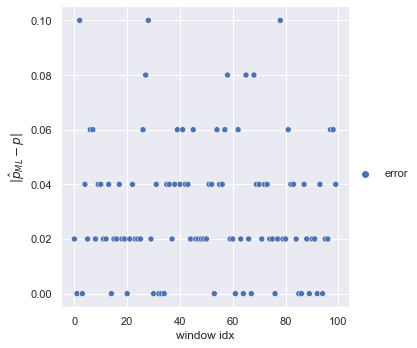

In [5]:
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
data = pd.DataFrame({"error": np.abs(ml_error)})
ax = sns.relplot(data=data)
ax.set(ylabel=r'$|\hat{p}_{ML}-p|$', xlabel="window idx")

## Bayesian

In [6]:
l = []
# initial prior is uniform
a = 1
b = 1
for _ in range(100):
    x = x_n.rvs(size=N, random_state=rng)
    n = np.sum(x)
    a += n
    b += N-n
    l.append((a-1)/(a+b-2))  # estimate using mode see wiki: https://en.wikipedia.org/wiki/Beta_distribution
rv = beta(a,b)
m,v = rv.stats(moments='mv')
p1_hat = np.array(l)
bayesian_error = p1_hat-p1
max_error = max(np.abs(bayesian_error))
MSE = np.power(np.abs(bayesian_error), 2).mean()

In [7]:
print("maximal estimation error: ", max_error)
print("MSE: ", MSE)

maximal estimation error:  0.020000000000000018
MSE:  4.50505961098781e-05


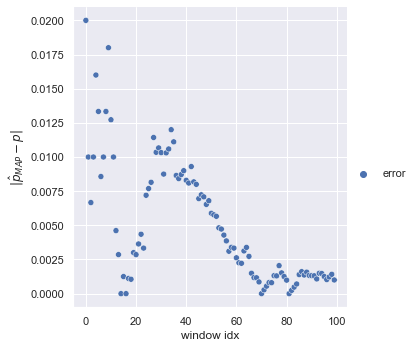

In [8]:
data = pd.DataFrame({"error": np.abs(bayesian_error)})
ax = sns.relplot(data=data)
ax.set(ylabel=r'$|\hat{p}_{MAP}-p|$', xlabel="window idx")

## Adding Noise

We now add the BSC channels noise. As shown above the received bits are still Bernoulli RVs but with a different parameter. Assume bit flips of 5% of bits.

In [9]:
f = 0.05
noise = bernoulli(f)

### MLE with noise

maximal estimation error:  0.16000000000000003
MSE:  0.005100000000000002


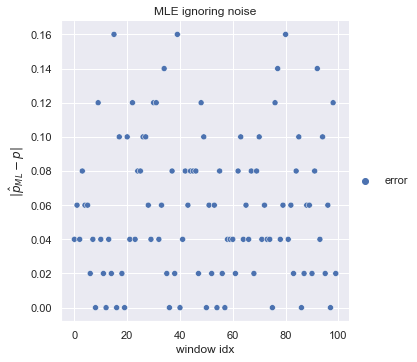

In [10]:
l = []
for _ in range(100):
    x = x_n.rvs(size=N, random_state=rng)
    w = noise.rvs(size=N, random_state=rng)
    x = np.mod(x + w, 2)
    l.append(np.mean(x))
v_hat = np.array(l)
ml_error = v_hat-p1
max_error = max(np.abs(ml_error))
MSE = np.power(np.abs(ml_error), 2).mean()
print("maximal estimation error: ", max_error)
print("MSE: ", MSE)
data = pd.DataFrame({"error": np.abs(ml_error)})
ax = sns.relplot(data=data)
ax.set(ylabel=r'$|\hat{p}_{ML}-p|$', xlabel="window idx", title="MLE ignoring noise")

As expected, the added noise reduces the performance of the MLE. If we account for the noise effect (as shown above $Y$ has a differnt parameter):

maximal estimation error:  0.13333333333333341
MSE:  0.0032345679012345707


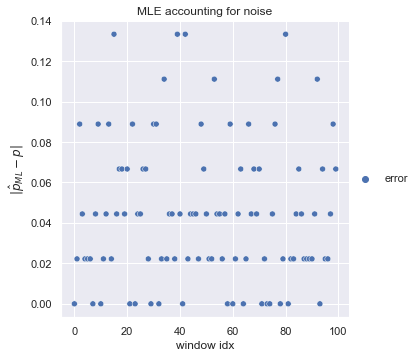

In [11]:
p1_hat = (v_hat-f)/(1-2*f)
ml_error = p1_hat-p1
max_error = max(np.abs(ml_error))
MSE = np.power(np.abs(ml_error), 2).mean()
print("maximal estimation error: ", max_error)
print("MSE: ", MSE)
data = pd.DataFrame({"error": np.abs(ml_error)})
ax = sns.relplot(data=data)
ax.set(ylabel=r'$|\hat{p}_{ML}-p|$', xlabel="window idx", title="MLE accounting for noise")

This doesn't seem to help either.

### Bayesian estimate with noise

maximal estimation error:  0.05777777777777782
MSE:  0.002081041717334456


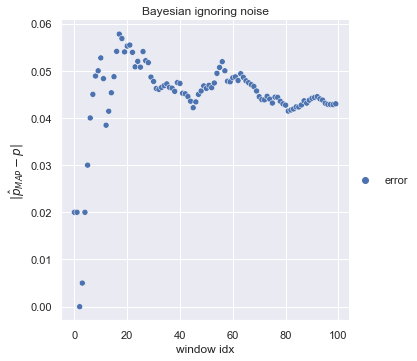

In [12]:
l = []
# initial prior is uniform
a = 1
b = 1
for _ in range(100):
    x = x_n.rvs(size=N, random_state=rng)
    w = noise.rvs(size=N, random_state=rng)
    x = np.mod(x + w, 2)
    n = np.sum(x)
    a += n
    b += N-n
    l.append((a-1)/(a+b-2))  # estimate using mode see wiki: https://en.wikipedia.org/wiki/Beta_distribution
v_hat = np.array(l)
estimation_error = v_hat-p1
max_error = max(np.abs(estimation_error))
MSE = np.power(np.abs(estimation_error), 2).mean()
print("maximal estimation error: ", max_error)
print("MSE: ", MSE)
data = pd.DataFrame({"error": np.abs(estimation_error)})
ax = sns.relplot(data=data)
ax.set(ylabel=r'$|\hat{p}_{MAP}-p|$', xlabel="window idx", title="Bayesian ignoring noise")

maximal estimation error:  0.06666666666666665
MSE:  0.00016913629667066052


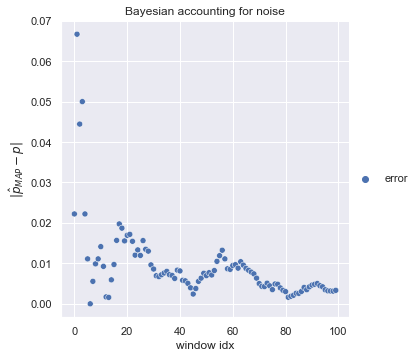

In [13]:
p1_hat = (v_hat-f)/(1-2*f)
ml_error = p1_hat-p1
max_error = max(np.abs(ml_error))
MSE = np.power(np.abs(ml_error), 2).mean()
print("maximal estimation error: ", max_error)
print("MSE: ", MSE)
data = pd.DataFrame({"error": np.abs(ml_error)})
ax = sns.relplot(data=data)
ax.set(ylabel=r'$|\hat{p}_{MAP}-p|$', xlabel="window idx", title="Bayesian accounting for noise")

The Bayesian estimator seems to be generally better, and to benefit more from the knowledge regariding the noise.